In [1]:
import os
os.environ['HF_HOME'] = "/workspaces/LLM/huggingface_cache"
cache_dir = "/workspaces/LLM/huggingface_cache"

In [2]:
from transformers import file_utils

# 現在のキャッシュディレクトリを取得
cache_dir = file_utils.default_cache_path
print(f"Current HuggingFace cache directory: {cache_dir}")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current HuggingFace cache directory: /workspaces/LLM/huggingface_cache/transformers


In [3]:
# !pip install japanize-matplotlib

In [4]:
from transformers.trainer_utils import set_seed
# 乱数シードの固定
set_seed(42)

In [5]:
### データセットの準備
from pprint import pprint
from datasets import load_dataset

# HuggingFaceHubのllm-book/JGLUEのリポジトリから
# MARC-jaデータを読み込む
train_dataset = load_dataset(
    "llm-book/wrime-sentiment", name="MARC-ja", split="train"
)
valid_dataset = load_dataset(
    "llm-book/wrime-sentiment", name="MARC-ja", split="validation"
)
# pprintで見やすくする
pprint(train_dataset[0])


Using custom data configuration MARC-ja
Reusing dataset wrime-sentiment (/workspaces/LLM/huggingface_cache/datasets/llm-book___wrime-sentiment/MARC-ja/0.0.0/c49a65171c421f2ae4dd3db82595f499cf0d289ca6780a2aeddf710f22dd8a37)
Using custom data configuration MARC-ja
Reusing dataset wrime-sentiment (/workspaces/LLM/huggingface_cache/datasets/llm-book___wrime-sentiment/MARC-ja/0.0.0/c49a65171c421f2ae4dd3db82595f499cf0d289ca6780a2aeddf710f22dd8a37)


{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [6]:
pprint(train_dataset.features)

{'datetime': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['positive', 'negative'], id=None),
 'sentence': Value(dtype='string', id=None),
 'user_id': Value(dtype='int64', id=None)}


### トークナイザー

In [7]:
# !pip install transformers[ja,sentencepice]

In [8]:
from transformers import AutoTokenizer

# HuggingFaceHub上のモデル名を指定
model_name = "tohoku-nlp/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(type(tokenizer).__name__)

BertJapaneseTokenizer


In [9]:
tokenizer.tokenize("これはテストです")

['これ', 'は', 'テスト', 'です']

In [10]:
encoded_input = tokenizer("これはテストです。")
# 出力されたオブジェクトのクラスを表示
print(type(encoded_input).__name__)

BatchEncoding


In [11]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [12]:
# 特殊トークンの確認
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

### データセット統計の可視化

100%|██████████| 20149/20149 [00:05<00:00, 3794.49it/s]


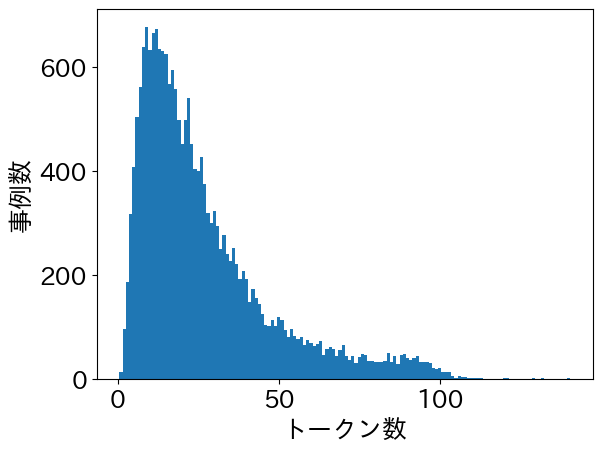

100%|██████████| 1608/1608 [00:00<00:00, 3643.89it/s]


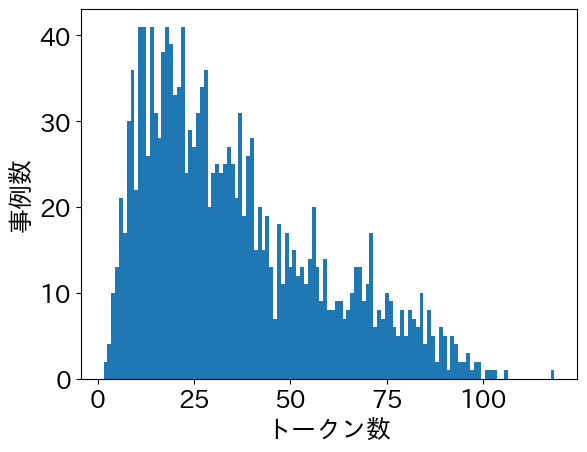

In [17]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()
    
visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

In [18]:
# レビュー内容サンプル確認
for data in valid_dataset:
    if len(tokenizer.tokenize(data["sentence"])) < 10:
        pprint(data)

{'datetime': '2020/5/15 17:35',
 'label': 1,
 'sentence': 'よくわからない連携。',
 'user_id': 26}
{'datetime': '2020/5/15 17:47',
 'label': 1,
 'sentence': 'この3年が無駄になった。',
 'user_id': 26}
{'datetime': '2020/5/15 17:48',
 'label': 1,
 'sentence': '空気を読んでなくて。',
 'user_id': 26}
{'datetime': '2020/5/15 17:52',
 'label': 1,
 'sentence': 'っていうか、英語の聞きすぎ',
 'user_id': 26}
{'datetime': '2020/5/18 16:31',
 'label': 0,
 'sentence': '明日は楽しみかも。',
 'user_id': 26}
{'datetime': '2020/5/19 11:55',
 'label': 1,
 'sentence': '今日は誤字だらけ。',
 'user_id': 26}
{'datetime': '2020/5/21 8:29',
 'label': 0,
 'sentence': 'SUNがいいなと思った。',
 'user_id': 26}
{'datetime': '2020/5/5 6:50',
 'label': 0,
 'sentence': 'わさび醤油、結構合う。',
 'user_id': 28}
{'datetime': '2020/5/6 6:13',
 'label': 1,
 'sentence': '朝から本当に腹立たしい。',
 'user_id': 28}
{'datetime': '2020/5/6 6:27',
 'label': 1,
 'sentence': 'しかも本人は反省の色なし',
 'user_id': 28}
{'datetime': '2020/5/6 8:18', 'label': 1, 'sentence': '書けない', 'user_id': 28}
{'datetime': '2020/3/2 19:32',
 'label':

100%|██████████| 20149/20149 [00:01<00:00, 15501.33it/s]


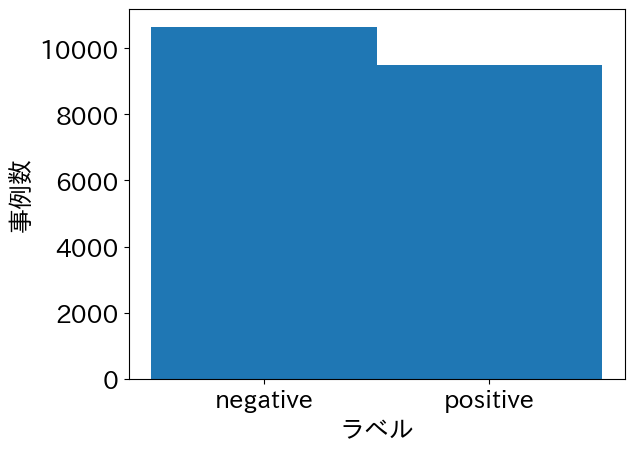

100%|██████████| 1608/1608 [00:00<00:00, 15332.39it/s]


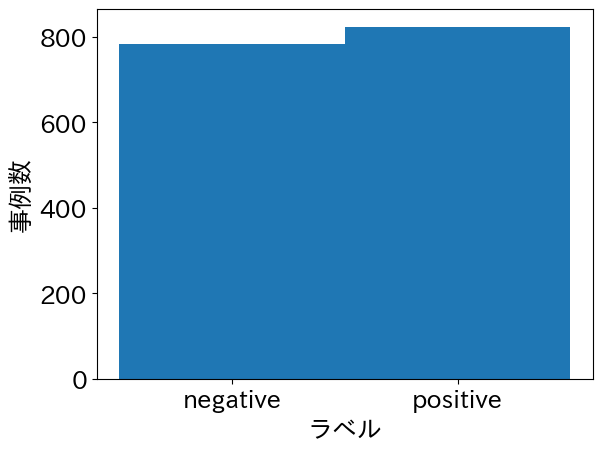

In [19]:
# ラベルの分布確認
def  visualize_label(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in tqdm(dataset):
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()
    
visualize_label(train_dataset)
visualize_label(valid_dataset)

### データセットの前処理

In [20]:
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文章分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["label"]
    return encoded_example

In [21]:
# データセット全体をトークナイゼーション
encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names
)

Loading cached processed dataset at /workspaces/LLM/huggingface_cache/datasets/llm-book___wrime-sentiment/MARC-ja/0.0.0/c49a65171c421f2ae4dd3db82595f499cf0d289ca6780a2aeddf710f22dd8a37/cache-25b9488f706c3063.arrow
Loading cached processed dataset at /workspaces/LLM/huggingface_cache/datasets/llm-book___wrime-sentiment/MARC-ja/0.0.0/c49a65171c421f2ae4dd3db82595f499cf0d289ca6780a2aeddf710f22dd8a37/cache-1852e9b08f832331.arrow


In [22]:
pprint(encoded_train_dataset[0])

{'attention_mask': [1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1],
 'input_ids': [2,
               478,
               7139,
               15269,
               441,
               456,
               13123,
               21311,
               12671,
               385,
               12651,
               7065,
               12485,
               12488,
               13781,
               461,
               457,
               13030,
               464,
               461,
               29,
          

### ミニバッチ構築

In [23]:
# ミニバッチとパディングの実装
from transformers import DataCollatorWithPadding

data_collaor = DataCollatorWithPadding(tokenizer=tokenizer) # パディングに用いるダミーのトークンIDを取得するため

In [24]:
# data_collatorの挙動確認
batch_inputs = data_collaor(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


### モデルの準備

In [25]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes, 
    label2id=label2id, # ラベル名からIDへの対応を指定
    id2label=id2label # IDからラベルへの対応を指定
)
print(type(model).__name__)

Some weights of the model checkpoint at tohoku-nlp/bert-base-japanese-v3 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification


In [26]:
# forward
print(model.forward(**data_collaor(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(0.7499, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0755,  0.1869],
        [ 0.3045,  0.0093],
        [ 0.4099, -0.2517],
        [ 0.3643,  0.2986]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


### 訓練の実施

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_marc_ja", # 結果保存のフォルダ
    per_device_train_batch_size=32, # 訓練時のバッチサイズ
    per_device_eval_batch_size=32, # 評価時のバッチサイズ
    learning_rate=2e-5, # 学習率
    lr_scheduler_type="linear", # 学習率スケジューラーの種類
    warmup_ratio=0.1, # 学習率のウォームアップの長さを指定
    num_train_epochs=3, # エポック数
    save_strategy="epoch", # チェックポイントの保存タイミング
    logging_strategy="epoch", # ロギングのタイミング
    evaluation_strategy="epoch", # 検証セットによる評価のタイミング
    load_best_model_at_end=True, # 訓練後に開発セットで最良モデルをロード
    metric_for_best_model="accuracy", # 最良モデルを決定する評価指標
    fp16=True, # 自動混合精度演算の有効化
)

In [28]:
# モデル評価方法の定義
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルにについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [29]:
# 学習の開始
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collaor,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20149
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1890


Epoch,Training Loss,Validation Loss,Accuracy
1,0.305400,0.172170,0.937811
2,0.139200,0.186074,0.935323
3,0.066900,0.236570,0.942164


***** Running Evaluation *****
  Num examples = 1608
  Batch size = 32
Saving model checkpoint to output_marc_ja/checkpoint-630
Configuration saved in output_marc_ja/checkpoint-630/config.json
Model weights saved in output_marc_ja/checkpoint-630/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1608
  Batch size = 32
Saving model checkpoint to output_marc_ja/checkpoint-1260
Configuration saved in output_marc_ja/checkpoint-1260/config.json
Model weights saved in output_marc_ja/checkpoint-1260/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1608
  Batch size = 32
Saving model checkpoint to output_marc_ja/checkpoint-1890
Configuration saved in output_marc_ja/checkpoint-1890/config.json
Model weights saved in output_marc_ja/checkpoint-1890/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output_marc_ja/checkpoint-1890 (score: 0.9421641791044776).


TrainOutput(global_step=1890, training_loss=0.17051666098296958, metrics={'train_runtime': 187.8866, 'train_samples_per_second': 321.721, 'train_steps_per_second': 10.059, 'total_flos': 2736062573028180.0, 'train_loss': 0.17051666098296958, 'epoch': 3.0})

### 訓練後のモデル評価

In [30]:
# 検証セットでモデル評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

***** Running Evaluation *****
  Num examples = 1608
  Batch size = 32


{'epoch': 3.0,
 'eval_accuracy': 0.9421641791044776,
 'eval_loss': 0.23656997084617615,
 'eval_runtime': 1.4448,
 'eval_samples_per_second': 1112.961,
 'eval_steps_per_second': 35.299}


## 感情分析モデルのエラー分析

### モデルの予測結果の取得

In [2]:
import torch
device = 0 if torch.cuda.is_available() else -1
device

0

In [44]:
from transformers import pipeline

import torch
device = 0 if torch.cuda.is_available() else -1

model_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device=device)

loading configuration file https://huggingface.co/llm-book/bert-base-japanese-v3-wrime-sentiment/resolve/main/config.json from cache at /workspaces/LLM/huggingface_cache/transformers/d017da05388cb51a002e5f5e997a0deb642aeab41b7abe15fa569542bdcb03b9.fc6acbaccc6ba34b5fa5e1741a66f105ebf02c89a21234678ab24deb1f65b769
Model config BertConfig {
  "_name_or_path": "llm-book/bert-base-japanese-v3-wrime-sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "p

In [42]:
# データセットの読み込み
from datasets import load_dataset

valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")

W1014 09:08:01.500471 140004139278336 builder.py:463] Using custom data configuration default


Dataset wrime-sentiment downloaded and prepared to /workspaces/LLM/huggingface_cache/datasets/llm-book___wrime-sentiment/default/0.0.0/c49a65171c421f2ae4dd3db82595f499cf0d289ca6780a2aeddf710f22dd8a37. Subsequent calls will reuse this data.


In [45]:
from tqdm import tqdm

# クラス名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    # 正解ラベルIDをラベル名に変更
    true_label = class_label.int2str(example["label"])
    
    # resultに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )
    

8it [00:00, 25.39it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
1608it [00:15, 103.51it/s]


### 全体的な傾向の分析

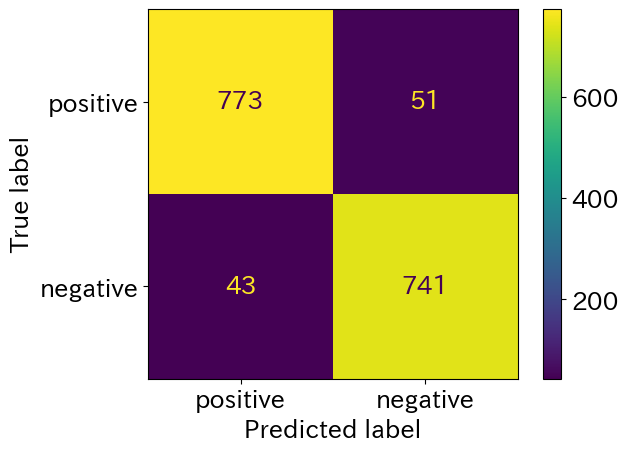

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18

# 混合行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# 混合行列を画像をして表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

### モデルのショートカットに注意

In [49]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文: {review_text}")
    print(f"予測: {top_result['pred_label']}")
    print(f"正解: {top_result['true_label']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("-------------")

レビュー文: 何のこれしき会社員だった頃の辛さに比べれば。まあ種類が違うけど。


予測: negative
正解: positive
予測確率: 0.9993
-------------
レビュー文: 今年のプリキュアの決め台詞が、
 
「お大事に」

今年にマッチングし過ぎてて、プリキュアスタッフの先見の明がすご過ぎるし、何が言いたいかと言うと変身する棒を買わされました。
予測: positive
正解: negative
予測確率: 0.9993
-------------
レビュー文: ツイッター早朝部、いくわよ！！ あと諸事情により数人ブロックさせて頂きました…申し訳ない……
予測: negative
正解: positive
予測確率: 0.9992
-------------
レビュー文: 酒はぬるめの 燗がいい 肴は炙った イカでいい←もっといいもの食えよ
予測: positive
正解: negative
予測確率: 0.9992
-------------
レビュー文: できれば今すぐお線香あげにいきたい
予測: positive
正解: negative
予測確率: 0.9992
-------------


### 自然言語推論

#### データセットの準備

In [5]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/JGLUEのリポジトリから
# JNLIのデータセットを読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation"
)
pprint(train_dataset[0])

Reusing dataset jglue (/workspaces/LLM/huggingface_cache/datasets/llm-book___jglue/JNLI/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f)
Reusing dataset jglue (/workspaces/LLM/huggingface_cache/datasets/llm-book___jglue/JNLI/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f)


{'label': 2,
 'sentence1': '二人の男性がジャンボジェット機を見ています。',
 'sentence2': '2人の男性が、白い飛行機を眺めています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '100124-104404-104405'}


In [6]:
pprint(train_dataset.features)

{'label': ClassLabel(num_classes=3,
                     names=['entailment', 'contradiction', 'neutral'],
                     id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'sentence_pair_id': Value(dtype='string', id=None),
 'yjcaptions_id': Value(dtype='string', id=None)}


#### トークナイザー

In [7]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "tohoku-nlp/bert-base-japanese-v3"
# モデル名からトークナイザーを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)

#### データセット統計の可視化

100%|██████████| 20073/20073 [00:05<00:00, 3514.88it/s]


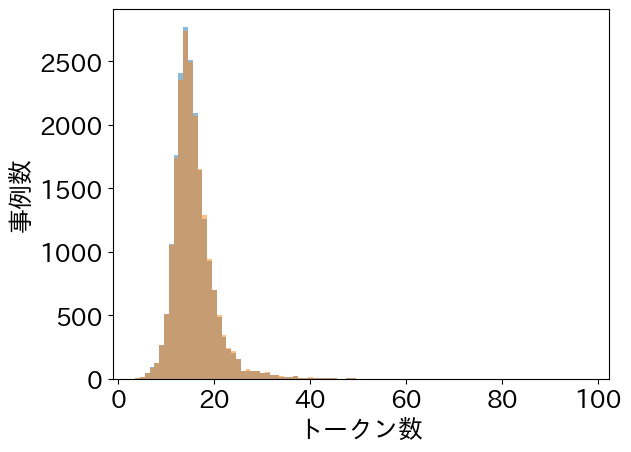

100%|██████████| 2434/2434 [00:00<00:00, 3884.38it/s]


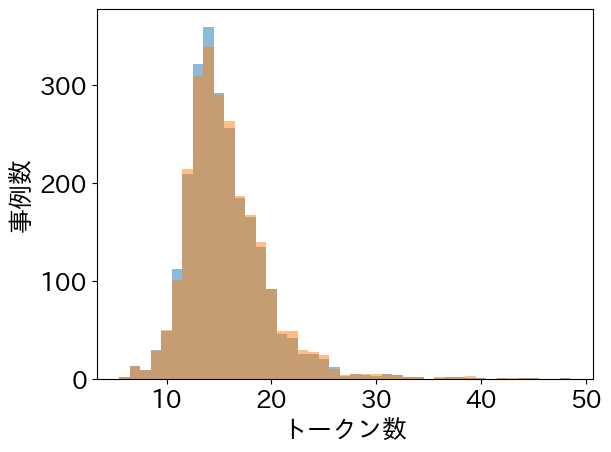

In [8]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを整える
    length_counter1 = Counter()
    length_counter2 = Counter()
    for data in tqdm(dataset):
        length1 = len(tokenizer.tokenize(data["sentence1"]))
        length_counter1[length1] += 1
        length2 = len(tokenizer.tokenize(data["sentence2"]))
        length_counter2[length2] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter1.keys(), length_counter1.values(), width=1.0, alpha=0.5)
    plt.bar(length_counter2.keys(), length_counter2.values(), width=1.0, alpha=0.5)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()
    
visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

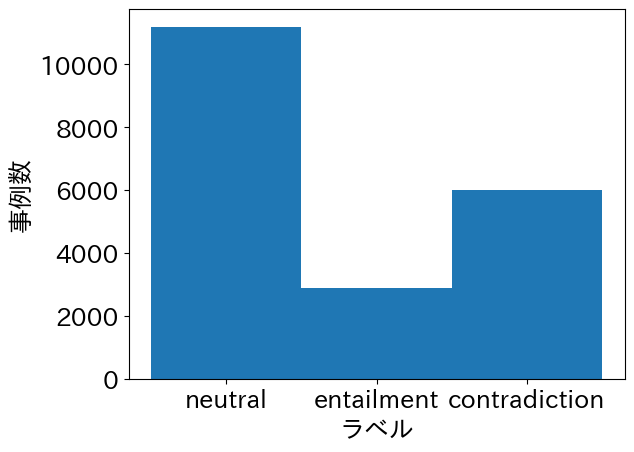

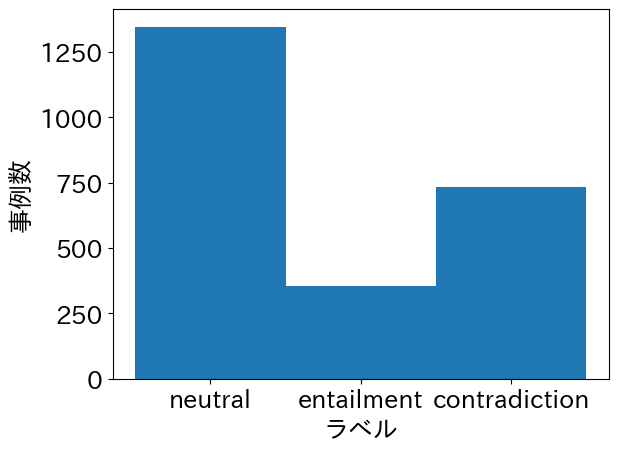

In [9]:
def visualize_labels(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベル数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()
    
visualize_labels(train_dataset)
visualize_labels(valid_dataset)

#### データセットの前処理

In [11]:
from transformers import BatchEncoding

def preprocess_text_pair_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文ペア関係予測の事項をトークナイズし、IDに変換"""
    # 出力は"input_ids", "token_type_ids", "attention_mask"をkeyとし、
    # list[int]をvalueとするBatchEncodingオブジェクト
    encoded_example = tokenizer(
        example["sentence1"], example["sentence2"], max_length=128
    )
    
    # 以降で使うモデルのBertForSequenceClassificationのforwardメソッドが
    # list[int]をvalueとするBatchEncodingオブジェクト
    encoded_example["labels"] = example["label"]
    return encoded_example

In [12]:
# 2つのテキストのトークンが出力されること確認
from transformers import AutoTokenizer

transformers_model_name = model_name
tokenizer = AutoTokenizer.from_pretrained(transformers_model_name)

example = train_dataset[0]
encoded_example = preprocess_text_pair_classification(example)
print(tokenizer.convert_ids_to_tokens(encoded_example["input_ids"]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['[CLS]', '二人', 'の', '男性', 'が', 'ジャンボ', 'ジェット', '機', 'を', '見', 'て', 'い', 'ます', '。', '[SEP]', '2', '人', 'の', '男性', 'が', '、', '白い', '飛行', '機', 'を', '眺め', 'て', 'い', 'ます', '。', '[SEP]']


In [13]:
### 前処理
encoded_train_dataset = train_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=valid_dataset.column_names,
)

100%|██████████| 2434/2434 [00:00<00:00, 3199.21ex/s]


In [14]:
print(encoded_train_dataset[0])

{'input_ids': [2, 14269, 464, 13341, 430, 27914, 16753, 3107, 500, 5538, 456, 422, 12995, 385, 3, 33, 680, 464, 13341, 430, 384, 16517, 13208, 3107, 500, 29887, 456, 422, 12995, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 2}


#### ミニバッチ構築

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 31]),
 'input_ids': torch.Size([4, 31]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 31])}


#### モデルの準備

In [19]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id, # ラベル名からIDへの対応を指定
    id2label=id2label, # IDからラベル名への対応を指定
)
print(type(model).__name__)

# パラメータをメモリ上に隣接した形で記憶
# これを実行しない場合、モデルの保存でエラーになる場合がある
for param in model.parameters():
    param.data = param.data.contiguous()

Some weights of the model checkpoint at tohoku-nlp/bert-base-japanese-v3 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification


In [20]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(1.3709, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.5438, -0.6999, -0.6652],
        [ 0.5443, -0.6911, -0.6591],
        [ 0.5689, -0.7136, -0.6473],
        [ 0.5303, -0.7133, -0.6069]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### 訓練の実行

In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jnli",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    num_train_epochs=3,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none", # 外部ツールへのログを無効化
)

In [22]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, int]:
    predictions, label = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions==label).mean()}

In [23]:
### 学習
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20073
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1884


Epoch,Training Loss,Validation Loss,Accuracy
1,0.500100,0.318159,0.886606
2,0.213300,0.305609,0.901397
3,0.128300,0.355679,0.898932


***** Running Evaluation *****
  Num examples = 2434
  Batch size = 32
Saving model checkpoint to output_jnli/checkpoint-628
Configuration saved in output_jnli/checkpoint-628/config.json
Model weights saved in output_jnli/checkpoint-628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2434
  Batch size = 32
Saving model checkpoint to output_jnli/checkpoint-1256
Configuration saved in output_jnli/checkpoint-1256/config.json
Model weights saved in output_jnli/checkpoint-1256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2434
  Batch size = 32
Saving model checkpoint to output_jnli/checkpoint-1884
Configuration saved in output_jnli/checkpoint-1884/config.json
Model weights saved in output_jnli/checkpoint-1884/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output_jnli/checkpoint-1256 (score: 0.9013968775677896).


TrainOutput(global_step=1884, training_loss=0.2806084302833379, metrics={'train_runtime': 177.1105, 'train_samples_per_second': 340.008, 'train_steps_per_second': 10.637, 'total_flos': 1651171850205822.0, 'train_loss': 0.2806084302833379, 'epoch': 3.0})

#### 訓練後のモデルの評価

In [24]:
# 検証セットでモデル評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

***** Running Evaluation *****
  Num examples = 2434
  Batch size = 32


{'epoch': 3.0,
 'eval_accuracy': 0.9013968775677896,
 'eval_loss': 0.30560895800590515,
 'eval_runtime': 2.1831,
 'eval_samples_per_second': 1114.926,
 'eval_steps_per_second': 35.271}


### 意味的類似度計算

#### 意味的類似度計算

In [2]:
# 乱数シードの固定
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

#### データセットの準備

In [4]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/JGLUEのリポジトリから
# JSTSのデータセット読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="validation"
)

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1546.57it/s]


Dataset jglue downloaded and prepared to /root/.cache/huggingface/datasets/llm-book___jglue/JSTS/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f. Subsequent calls will reuse this data.


W1027 06:15:07.709398 139717496147968 builder.py:641] Reusing dataset jglue (/root/.cache/huggingface/datasets/llm-book___jglue/JSTS/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f)


In [5]:
# pprintで見やすく表示
pprint(train_dataset[0])

{'label': 0.0,
 'sentence1': '川べりでサーフボードを持った人たちがいます。',
 'sentence2': 'トイレの壁に黒いタオルがかけられています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '10005_480798-10996-92616'}


In [6]:
pprint(train_dataset.features)

{'label': Value(dtype='float32', id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'sentence_pair_id': Value(dtype='string', id=None),
 'yjcaptions_id': Value(dtype='string', id=None)}


#### トークンナイザ

In [7]:
from transformers import AutoTokenizer
# Hugging Face Hub上のモデル名を指定
model_name = "tohoku-nlp/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)

https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpj7o28hxk
storing https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8043b59e7a9639c56214adaed095b3cbf0d5092149be4d1f965b6acb30b8d3e1.4808e98b4c322931918efdb7a04a39d4791c7057a124ebb424f0c33b64ff0b04
creating metadata file for /root/.cache/huggingface/transformers/8043b59e7a9639c56214adaed095b3cbf0d5092149be4d1f965b6acb30b8d3e1.4808e98b4c322931918efdb7a04a39d4791c7057a124ebb424f0c33b64ff0b04
https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp17ebxk86
storing https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/vocab.txt in cache at /root/.cache/huggingface/tr

100%|██████████| 12451/12451 [00:03<00:00, 3933.20it/s]


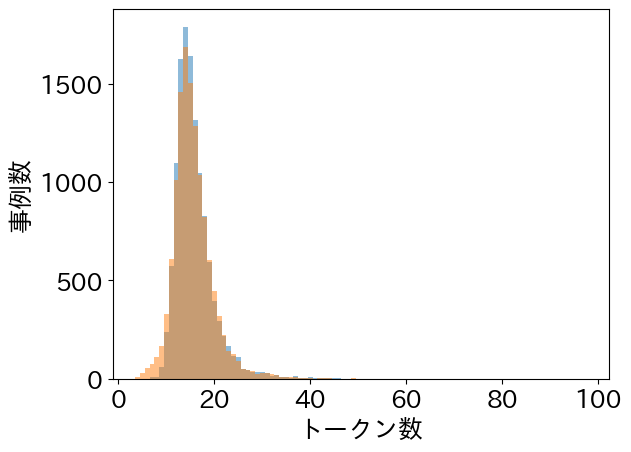

100%|██████████| 1457/1457 [00:00<00:00, 4062.45it/s]


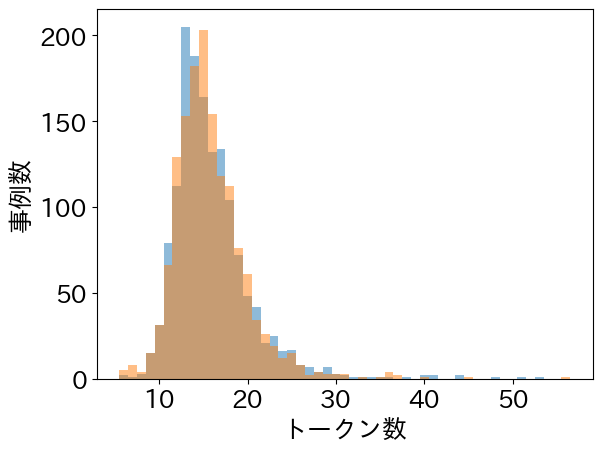

In [8]:
#### データセット統計の可視化
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter1 = Counter()
    length_counter2 = Counter()
    for data in tqdm(dataset):
        length1 = len(tokenizer.tokenize(data["sentence1"]))
        length_counter1[length1] += 1
        length2 = len(tokenizer.tokenize(data["sentence2"]))
        length_counter2[length2] += 1
        
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter1.keys(), length_counter1.values(), width=1.0, alpha=0.5)
    plt.bar(length_counter2.keys(), length_counter2.values(), width=1.0, alpha=0.5)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()
    
visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

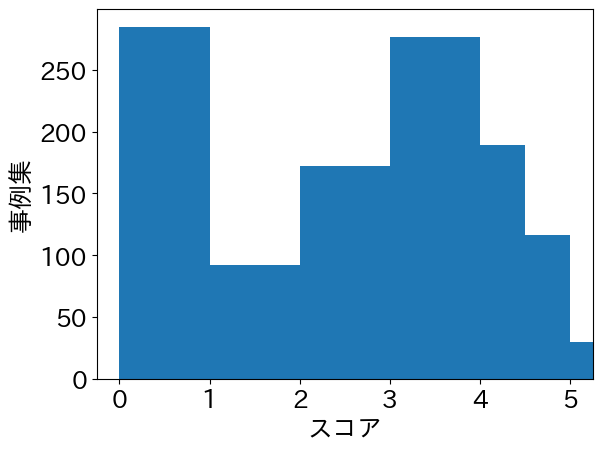

In [9]:
def visualize_scores(dataset: Dataset):
    """データセット中のスコア分布をグラフとして描画"""
    # データセット中のスコアを抽出
    scores = []
    for data in dataset:
        scores.append(data["label"])
        
    # label_counterを棒グラフとして描画する
    plt.hist(scores, width=1.0)
    plt.xlabel("スコア")
    plt.ylabel("事例集")
    plt.show()
    
visualize_scores(valid_dataset)

#### データセットの前処理

In [10]:
from transformers import BatchEncoding

def preprocess_text_pair_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文ペア関係予測の事例をトークナイズし、IDに変換"""
    # 出力は"input_ids", "token_type_ids", "attention_mask"をkeyとし、
    # list[int]をvalueとするBatchEncodingオブジェクト
    encoded_example = tokenizer(
        example["sentence1"], example["sentence2"], max_length=128
    )
    
    # 以降で使うモデルのBertForSequenceClassificationのforwardメソッドが
    # 受け取るラベルの引数名に合わせて"labels"をキーにする
    encoded_example["labels"] = example["label"]
    return encoded_example
    

In [12]:
### 前処理の適用
encoded_train_dataset = train_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=valid_dataset.column_names,
)

100%|██████████| 12451/12451 [00:04<00:00, 3040.52ex/s]
W1027 06:34:10.325295 139717496147968 arrow_dataset.py:2608] Loading cached processed dataset at /root/.cache/huggingface/datasets/llm-book___jglue/JSTS/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f/cache-8178bab62d7a102a.arrow


In [13]:
print(encoded_train_dataset[0])

{'input_ids': [2, 1943, 7740, 7234, 457, 12840, 7076, 15950, 500, 13008, 449, 680, 12626, 430, 422, 12995, 385, 3, 17884, 464, 1549, 461, 16568, 32500, 430, 12790, 12504, 456, 422, 12995, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 0.0}


#### ミニバッチ構築

In [14]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 32]),
 'input_ids': torch.Size([4, 32]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 32])}


#### モデルの準備

In [16]:
from transformers import AutoModelForSequenceClassification

transformers_model_name = "tohoku-nlp/bert-base-japanese-v3"

model = AutoModelForSequenceClassification.from_pretrained(
    transformers_model_name,
    num_labels=1,
    problem_type="regression"
)

https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpch4znfom
storing https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/2c9ec44dde23b6b02ec9f34997dd1595677490da33cc6f7f5931a82fea500ef1.fa452780f4f534fd5a9a500fd6dc0ab2b41b7f3a87fde31e4e439dacbbe6eea3
creating metadata file for /root/.cache/huggingface/transformers/2c9ec44dde23b6b02ec9f34997dd1595677490da33cc6f7f5931a82fea500ef1.fa452780f4f534fd5a9a500fd6dc0ab2b41b7f3a87fde31e4e439dacbbe6eea3
loading configuration file https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/2c9ec44dde23b6b02ec9f34997dd1595677490da33cc6f7f5931a82fea500ef1.fa452780f4f534fd5a9a500fd6dc0ab2b41b7f3a87fde31e4e439dacbbe6eea3
Model config BertConfig {
  "_name_or_path": "toho

In [17]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(6.4943, grad_fn=<MseLossBackward0>), logits=tensor([[0.2608],
        [0.3047],
        [0.2998],
        [0.1691]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### 訓練の実行

In [18]:
### 訓練時のパラメータ設定
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../model/output_jsts",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="spearmanr",
    fp16=True,
    report_to="none",
)

PyTorch: setting up devices


In [25]:
### 評価関数
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_correlation_metrics(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測スコアと正解スコアから各種相関係数を計算"""
    predictions, labels = eval_pred
    predictions = predictions.squeeze(1)
    
    # pearsonrとspearmanrは (相関係数, p値) のタプルを返す
    pearson_corr, _ = pearsonr(predictions, labels)
    spearman_corr, _ = spearmanr(predictions, labels)
    
    return {
        "pearsonr": pearson_corr,
        "spearmanr": spearman_corr,
    }

In [26]:
### モデル学習
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_correlation_metrics
)

trainer.train()

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 12451
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1170


Epoch,Training Loss,Validation Loss,Pearsonr,Spearmanr
1,0.117300,0.389991,0.902292,0.864971
2,0.225900,0.332706,0.914415,0.873066
3,0.156700,0.342210,0.914347,0.874876


***** Running Evaluation *****
  Num examples = 1457
  Batch size = 32
Saving model checkpoint to ../model/output_jsts/checkpoint-390
Configuration saved in ../model/output_jsts/checkpoint-390/config.json
Model weights saved in ../model/output_jsts/checkpoint-390/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1457
  Batch size = 32
Saving model checkpoint to ../model/output_jsts/checkpoint-780
Configuration saved in ../model/output_jsts/checkpoint-780/config.json
Model weights saved in ../model/output_jsts/checkpoint-780/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1457
  Batch size = 32
Saving model checkpoint to ../model/output_jsts/checkpoint-1170
Configuration saved in ../model/output_jsts/checkpoint-1170/config.json
Model weights saved in ../model/output_jsts/checkpoint-1170/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ../model/output_jsts/checkpoint-1170 (sco

TrainOutput(global_step=1170, training_loss=0.16661641373593583, metrics={'train_runtime': 116.6566, 'train_samples_per_second': 320.196, 'train_steps_per_second': 10.029, 'total_flos': 1012209974990184.0, 'train_loss': 0.16661641373593583, 'epoch': 3.0})

#### 訓練後のモデルの評価

In [27]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

***** Running Evaluation *****
  Num examples = 1457
  Batch size = 32


{'epoch': 3.0,
 'eval_loss': 0.3422102928161621,
 'eval_pearsonr': 0.9143472987266228,
 'eval_runtime': 1.2279,
 'eval_samples_per_second': 1186.557,
 'eval_spearmanr': 0.8748760708118822,
 'eval_steps_per_second': 37.462}


In [35]:
### ファインチューニングしたモデルのpipelineを読み込む
from transformers import pipeline

text_sim_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-jsts",
    function_to_apply="none"
)
# pipelineを実行
text1 = "川べりでサーフボードを持った人たちがいます"
text2 = "サーファーたちが川べりに立っています"
print(text_sim_pipeline({"text": text1, "text_pair": text2})["score"])

loading configuration file https://huggingface.co/llm-book/bert-base-japanese-v3-jsts/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7416e18f43074b8a4059dd2a18c5812eb25ea29ea24198f571aa9db78b219e7b.9e91c324b28864465f8b22c7b8bb2288549254690364c4e88d6eb9396b3ee6a6
Model config BertConfig {
  "_name_or_path": "llm-book/bert-base-japanese-v3-jsts",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "regression",
  "torch_dtype": "float32",
  "transformers_v

3.5703558921813965


### 多肢選択式質問応答

In [1]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

#### データセットの準備

In [2]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/JGLUEのリポジトリから
# JCommonsenseQAのデータを読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="validation"
)
# pprintで見やすく表示する
pprint(train_dataset[0])

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1973.33it/s]


Dataset jglue downloaded and prepared to /root/.cache/huggingface/datasets/llm-book___jglue/JCommonsenseQA/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f. Subsequent calls will reuse this data.


W1111 08:04:20.396098 140136710688768 builder.py:641] Reusing dataset jglue (/root/.cache/huggingface/datasets/llm-book___jglue/JCommonsenseQA/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f)


{'choice0': '世界',
 'choice1': '写真集',
 'choice2': '絵本',
 'choice3': '論文',
 'choice4': '図鑑',
 'label': 2,
 'q_id': 0,
 'question': '主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？'}


In [3]:
pprint(train_dataset.features)

{'choice0': Value(dtype='string', id=None),
 'choice1': Value(dtype='string', id=None),
 'choice2': Value(dtype='string', id=None),
 'choice3': Value(dtype='string', id=None),
 'choice4': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=5,
                     names=['choice0',
                            'choice1',
                            'choice2',
                            'choice3',
                            'choice4'],
                     id=None),
 'q_id': Value(dtype='int64', id=None),
 'question': Value(dtype='string', id=None)}


### トークナイザー

In [5]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "tohoku-nlp/bert-base-japanese-v3"
# モデル名からトークナイザーを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading file https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/c9bc9ea10e626449e8b1e495b7732b9731759975f019624c92aa6360a07c72d7.e89607f19c59d268d8bab3289700c482c617a74844664e4996544f3e1a647db4
loading file https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8043b59e7a9639c56214adaed095b3cbf0d5092149be4d1f965b6acb30b8d3e1.4808e98b4c322931918efdb7a04a39d4791c7057a124ebb424f0c33b64ff0b04


#### データセット統計の可視化

In [6]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18

def visualize_question_length(dataset: Dataset):
    """データセット中の質問のトークン数の分布をグラフとして描画"""
    # データセット中の質問の長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["question"]))
        length_counter[length] += 1
        
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

100%|██████████| 8939/8939 [00:01<00:00, 4863.59it/s]


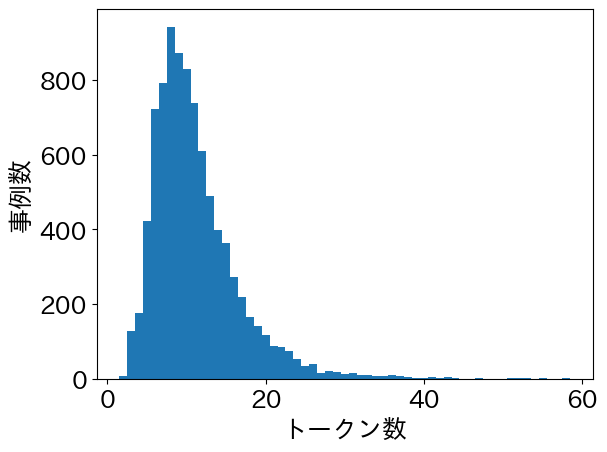

100%|██████████| 1119/1119 [00:00<00:00, 5702.40it/s]


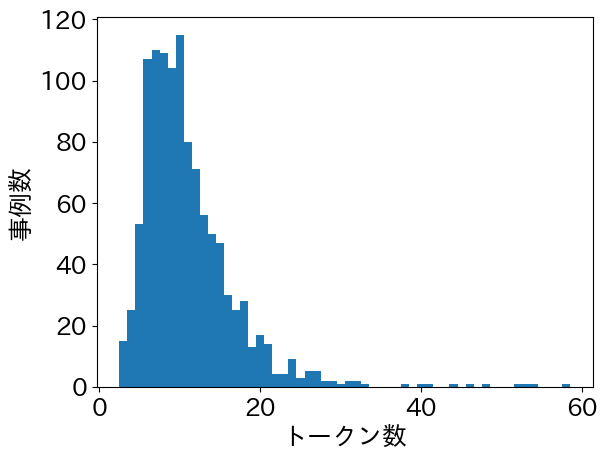

In [7]:
visualize_question_length(train_dataset)
visualize_question_length(valid_dataset)

100%|██████████| 8939/8939 [00:02<00:00, 3958.81it/s]


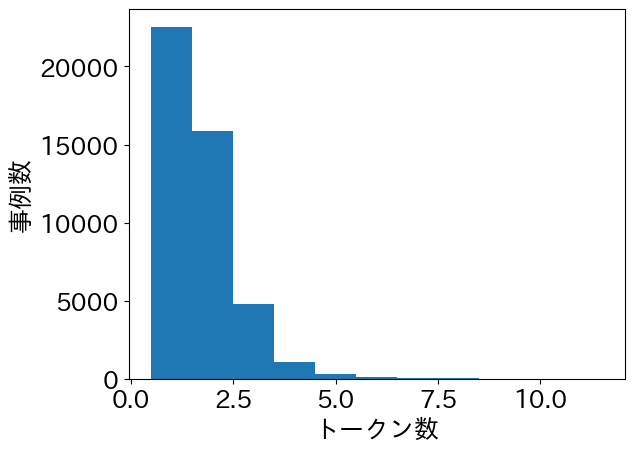

100%|██████████| 1119/1119 [00:00<00:00, 3931.23it/s]


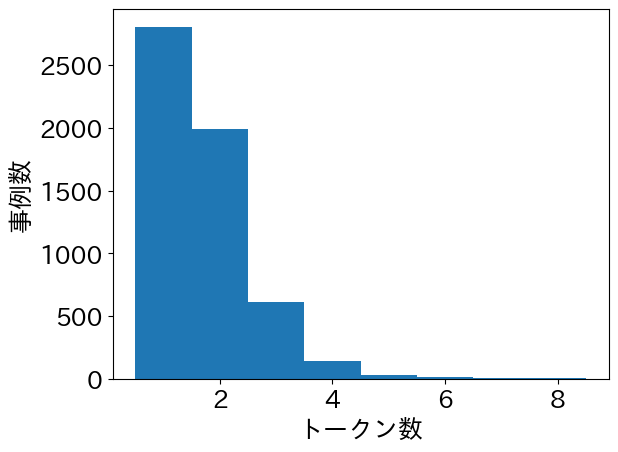

In [9]:
def visualize_choice_length(dataset: Dataset):
    """データセット中の選択肢のトークン数の分布をグラフとして描画"""
    # データセット中の選択肢の長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        for i in range(5):
            length = len(tokenizer.tokenize(data[f"choice{i}"]))
            length_counter[length] += 1
            
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()
    
visualize_choice_length(train_dataset)
visualize_choice_length(valid_dataset)

#### データセットの前処理

In [14]:
from transformers import BatchEncoding

def preprocess_multiple_choice(
    example: dict[str, str]
) -> BatchEncoding:
    """多肢選択肢質問応答の事例をIDに変換"""
    # 選択肢の数を"choice"から始まるキーの数として算出
    num_choices = sum(
        key.startswith("choice") for key in example.keys()
    )
    
    # 質問と選択肢を連結してトークナイザーに渡す
    choice_list = [example[f"choice{i}"] for i in range(num_choices)]
    repeated_question_list = [example["question"]] * num_choices
    encoded_example = tokenizer(
        repeated_question_list, choice_list, max_length=64
    )
    
    # ラベルが入力に含まれている場合、出力にも追加
    if "label" in example:
        encoded_example["labels"] = example["label"]
    return encoded_example

In [15]:
from transformers import AutoTokenizer

example = train_dataset[0]
encoded_example = preprocess_multiple_choice(example) # 事例の前処理
for choice in range(5):
    # IDから元の文字列を復元
    print(tokenizer.decode(encoded_example["input_ids"][choice]))

[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 世界 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 写真 集 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 絵本 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 論文 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 図鑑 [SEP]


In [16]:
encoded_train_dataset = train_dataset.map(
    preprocess_multiple_choice,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_multiple_choice,
    remove_columns=valid_dataset.column_names,
)

 46%|████▌     | 4128/8939 [00:03<00:03, 1237.45ex/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 1119/1119 [00:00<00:00, 1323.37ex/s]


In [17]:
print(encoded_train_dataset[0])

{'input_ids': [[2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 12575, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 13409, 6460, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 20647, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 15252, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 22929, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0

### ミニバッチ構築

In [19]:
import torch
from transformers import BatchEncoding

def collate_fn_multiple_choice(
    features: list[BatchEncoding],
) -> dict[str, torch.Tensor]:
    """選択肢式質問応答の入力からミニバッチを構築"""
    # preprocess_multiple_choice関数に合わせてラベル名を"labels"にする
    label_name = "labels"
    
    batch_size = len(features)
    num_choices = len(features[0]["input_ids"])
    
    # 選択肢ごとの入力を一つのlistにまとめる
    flat_features = []
    for feature in features:
        flat_features += [
            {k: v[i] for k, v in feature.items() if k != label_name}
            for i in range(num_choices)
        ]
        
    # 選択肢ごとの入力についてもパディングを行う
    flat_batch = tokenizer.pad(flat_features, return_tensors="pt")
    
    # 元のバッチごとに選択肢ごとの入力をまとめる
    # (バッチサイズ * 選択肢数, 最大系列長)の形をしたTensorを、
    # (バッチサイズ, 選択肢数, 最大系列長)に変換
    batch = {
        k: v.view(batch_size, num_choices, -1)
        for k, v in flat_batch.items()
    }
    
    # ラベルが入力に含まれている場合、バッチにまとめてTensorに変換
    if label_name in features[0]:
        labels = [feature[label_name] for feature in features]
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
    return batch

In [20]:
batch_size = 4
encoded_examples = [
    preprocess_multiple_choice(train_dataset[i])
    for i in range(batch_size)
]

batch = collate_fn_multiple_choice(encoded_examples)
pprint({name: tensor.size() for name, tensor in batch.items()})

{'attention_mask': torch.Size([4, 5, 40]),
 'input_ids': torch.Size([4, 5, 40]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 5, 40])}


#### モデルの準備

In [22]:
from transformers import AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained(
    model_name,
    num_labels=train_dataset.features["label"].num_classes,
)

# パラメータをメモリ上に隣接した形で配置
for param in model.parameters():
    param.data = param.data.contiguous()

loading configuration file https://huggingface.co/tohoku-nlp/bert-base-japanese-v3/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/2c9ec44dde23b6b02ec9f34997dd1595677490da33cc6f7f5931a82fea500ef1.fa452780f4f534fd5a9a500fd6dc0ab2b41b7f3a87fde31e4e439dacbbe6eea3
Model config BertConfig {
  "_name_or_path": "tohoku-nlp/bert-base-japanese-v3",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "p

In [23]:
model(**batch)

MultipleChoiceModelOutput(loss=tensor(1.4848, grad_fn=<NllLossBackward0>), logits=tensor([[-0.3795, -0.3648, -0.1021, -0.4802, -0.2815],
        [-0.0629,  0.0435, -0.4554, -0.1143, -0.2337],
        [-0.5503, -0.5156, -0.6268, -0.5746, -0.5088],
        [-0.4857, -0.4155, -0.5902, -0.2060, -0.2705]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

#### 訓練の実行

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../model/output_jcommonsenseqa",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none",
)

PyTorch: setting up devices


In [28]:
import numpy as np
def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions==labels).mean()}

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
     train_dataset=encoded_train_dataset,
     eval_dataset=encoded_valid_dataset,
     data_collator=collate_fn_multiple_choice,
     args=training_args,
     compute_metrics=compute_accuracy,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8939
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 840


Epoch,Training Loss,Validation Loss,Accuracy
1,0.207300,0.593048,0.835567
2,0.340900,0.465616,0.835567
3,0.218400,0.528967,0.833780


***** Running Evaluation *****
  Num examples = 1119
  Batch size = 32
Saving model checkpoint to ../model/output_jcommonsenseqa/checkpoint-280
Configuration saved in ../model/output_jcommonsenseqa/checkpoint-280/config.json
Model weights saved in ../model/output_jcommonsenseqa/checkpoint-280/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1119
  Batch size = 32
Saving model checkpoint to ../model/output_jcommonsenseqa/checkpoint-560
Configuration saved in ../model/output_jcommonsenseqa/checkpoint-560/config.json
Model weights saved in ../model/output_jcommonsenseqa/checkpoint-560/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1119
  Batch size = 32
Saving model checkpoint to ../model/output_jcommonsenseqa/checkpoint-840
Configuration saved in ../model/output_jcommonsenseqa/checkpoint-840/config.json
Model weights saved in ../model/output_jcommonsenseqa/checkpoint-840/pytorch_model.bin


Training completed. Do not forget to share your model on huggi

TrainOutput(global_step=840, training_loss=0.2555528822399321, metrics={'train_runtime': 134.3812, 'train_samples_per_second': 199.559, 'train_steps_per_second': 6.251, 'total_flos': 2305556727283980.0, 'train_loss': 0.2555528822399321, 'epoch': 3.0})

In [30]:
#### 訓練後のモデル評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

***** Running Evaluation *****
  Num examples = 1119
  Batch size = 32


{'epoch': 3.0,
 'eval_accuracy': 0.8355674709562109,
 'eval_loss': 0.593048095703125,
 'eval_runtime': 1.6528,
 'eval_samples_per_second': 677.041,
 'eval_steps_per_second': 21.176}


#### 学習済みモデルの予測結果の取得

In [31]:
from transformers import AutoModelForMultipleChoice, AutoTokenizer

model_name = "llm-book/bert-base-japanese-v3-jcommonsenseqa"
tokeniser = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMultipleChoice.from_pretrained(model_name)

https://huggingface.co/llm-book/bert-base-japanese-v3-jcommonsenseqa/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpkn93ft68
storing https://huggingface.co/llm-book/bert-base-japanese-v3-jcommonsenseqa/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/d5c4c9cae5c426bb714d883fb0f3f4896da9673fa81d8bd02dcb52b0c5dfc2d8.a5f7ab9af9f6a84e4c5714eff652410283ececd3ce47ca1228ea7ee36b2089a2
creating metadata file for /root/.cache/huggingface/transformers/d5c4c9cae5c426bb714d883fb0f3f4896da9673fa81d8bd02dcb52b0c5dfc2d8.a5f7ab9af9f6a84e4c5714eff652410283ececd3ce47ca1228ea7ee36b2089a2
https://huggingface.co/llm-book/bert-base-japanese-v3-jcommonsenseqa/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvfxam4eg
storing https://huggingface.co/llm-book/bert-base-japanese-v3-jcommonsenseqa/resolve/ma

In [32]:
# 文章分類できるpipelineの定義

def pipeline_multiple_choice(
    examples: dict[str, str] | list[dict[str, str]]
) -> list[dict[str, str]]:
    """多肢選択式質問応答の事例について予測"""
    # 単一のdict入力が与えられたときに、listに格納する
    if isinstance(examples, dict):
        examples = [examples]
        
    # 事例をモデルの入力形式に変換
    encoded_examples = [
        preprocess_multiple_choice(e) for e in examples
    ]
    batch = collate_fn_multiple_choice(encoded_examples)
    
    # モデルが使用するデバイス上（CPU/GPU）にデータを移動
    batch = {k: v.to(model.device) for k, v in batch.items()}
    
    # モデルのforward計算処理
    model_output = model.forward(**batch)
    
    # モデルの出力から、選択肢の文字列と予測確率を得る
    predicted_ids = model_output.logits.argmax(dim=-1).tolist()
    probs = torch.softmax(model_output.logits, dim=-1)
    predictes_probs = [ps[i].item() for ps, i in zip(probs, predicted_ids)]
    predictions = [
        {"prediction": e[f"choice{i}"], "pred_prob": p}
        for e, i, p in zip(examples, predicted_ids, predictes_probs)
    ]
    
    return predictions

In [33]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="validation"
)

W1111 09:10:36.031617 140136710688768 builder.py:641] Reusing dataset jglue (/root/.cache/huggingface/datasets/llm-book___jglue/JCommonsenseQA/1.1.0/b394a8dbefe82fb1dc2724c1eb79bb1ea3062df2037f91a69a27c089f3ff685f)


In [34]:
model = model.to("cuda:0")

In [36]:
from tqdm import tqdm

# ラベル名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を格納
    model_prediction = pipeline_multiple_choice(example)[0]
    # 正解の文字列を取得
    true_label = example["label"]
    correct_answer = example[f"choice{true_label}"]
    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["pred_prob"],
            "prediction": model_prediction["prediction"],
            "correct_answer": correct_answer,
        }
    )

472it [00:06, 73.16it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
1119it [00:15, 72.78it/s]


#### エラー分析

In [37]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["prediction"] != res["correct_answer"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位を表示
for top_result in sorted_failed_results[:10]:
    question = valid_dataset[top_result["example_id"]]["question"]
    
    print(f"問題: {question}")
    
    print(f"予測: {top_result['prediction']}")
    print(f"正解: {top_result['correct_answer']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("---------------")

問題: 何かに通るためにチャレンジする事とは？
予測: 合格する
正解: 受験
予測確率: 0.9998
---------------
問題: 朝に飲む汁物を何と呼ぶ？
予測: おかゆ
正解: スープ
予測確率: 0.9997
---------------
問題: 夜空に見える一番大きいものは？
予測: 星
正解: お月様
予測確率: 0.9989
---------------
問題: 芝居を行う建物を何という？
予測: スタジオ
正解: 演芸場
予測確率: 0.9984
---------------
問題: 場所取りする宴会とは？
予測: パーティ
正解: 花見
予測確率: 0.9971
---------------
問題: 船舶を安定させる物と同じ発音なのは、どれでしょう？
予測: 碇
正解: 怒り
予測確率: 0.9967
---------------
問題: そもそも・初めからなどを言い換えると？
予測: 終に
正解: 元は
予測確率: 0.9966
---------------
問題: 書き物をしたり本を読んだりするための場所はどこ？
予測: 書架
正解: 机
予測確率: 0.9959
---------------
問題: 脳はどこにある？
予測: 頭脳
正解: 頭
予測確率: 0.9959
---------------
問題: 今のご時世、感染予防には欠かせない店舗入り口にあるものは？
予測: 自動ドア
正解: 消毒する
予測確率: 0.9942
---------------


### 大規模言語モデルのファインチューニング

#### メモリ効率の良いファインチューニング

#### LoRAチューニング

In [ ]:
# !pip install peft

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 6.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 12.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_o

In [1]:
# 乱数シードの固定
from transformers.trainer_utils import set_seed
set_seed(42)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### データセットの準備
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のリポジトリからデータ読み込み
# データを読み込む
train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")
pprint(train_dataset[0])

Using custom data configuration default
Reusing dataset wrime-sentiment (/root/.cache/huggingface/datasets/llm-book___wrime-sentiment/default/0.0.0/c49a65171c421f2ae4dd3db82595f499cf0d289ca6780a2aeddf710f22dd8a37)
Using custom data configuration default
Reusing dataset wrime-sentiment (/root/.cache/huggingface/datasets/llm-book___wrime-sentiment/default/0.0.0/c49a65171c421f2ae4dd3db82595f499cf0d289ca6780a2aeddf710f22dd8a37)


{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [3]:
pprint(train_dataset.features)

{'datetime': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['positive', 'negative'], id=None),
 'sentence': Value(dtype='string', id=None),
 'user_id': Value(dtype='int64', id=None)}


#### トークナイザ

In [4]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "tohoku-nlp/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
# トークナイザのクラス名を確認
print(type(tokenizer).__name__)

BertJapaneseTokenizer


In [5]:
tokenizer.tokenize("これはテストです。")

['これ', 'は', 'テスト', 'です', '。']

In [6]:
encoded_input = tokenizer("これはテストです。")
# 出力されたオブジェクトのクラスを表示
print(type(encoded_input).__name__)

BatchEncoding


In [7]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [8]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

#### データセットの統計可視化

100%|██████████| 20149/20149 [00:04<00:00, 4968.70it/s]


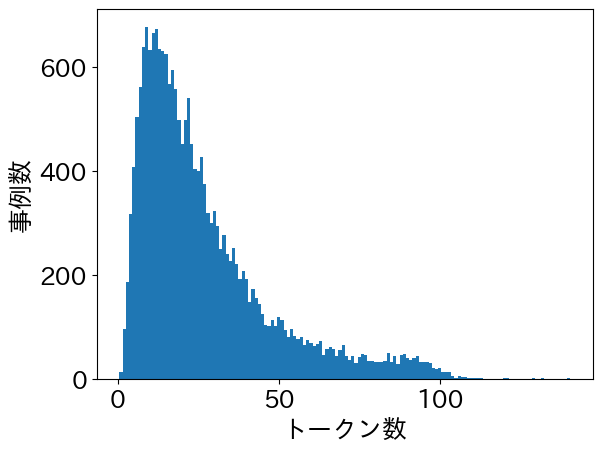

100%|██████████| 1608/1608 [00:00<00:00, 4160.41it/s]


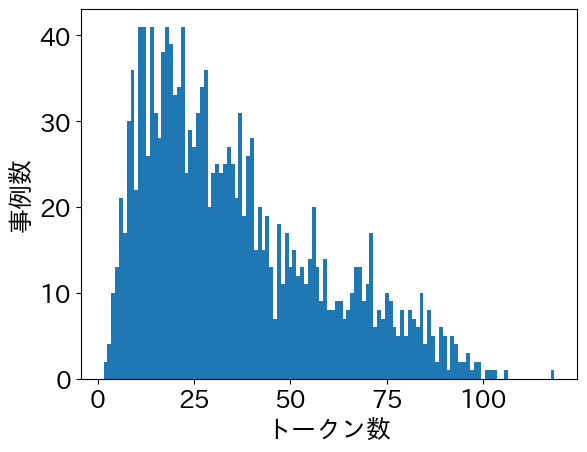

In [9]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()
    
visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

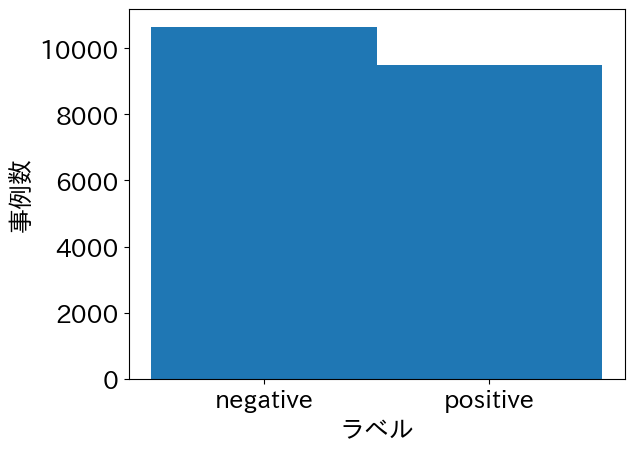

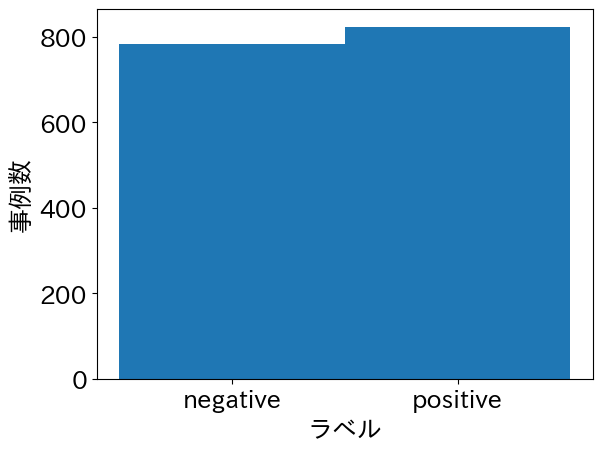

In [10]:
def visualize_labels(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中にラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()
    
visualize_labels(train_dataset)
visualize_labels(valid_dataset)

#### データセットの前処理

In [11]:
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文章分類の事例のテキストをトークナイズし、ID変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["label"]
    return encoded_example

In [12]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)

100%|██████████| 1608/1608 [00:00<00:00, 2908.25ex/s]


In [13]:
print(encoded_train_dataset[0])

{'input_ids': [2, 478, 7139, 15269, 441, 456, 13123, 21311, 12671, 385, 12651, 7065, 12485, 12488, 13781, 461, 457, 13030, 464, 461, 29, 29, 29, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1}


#### ミニバッチ構築

In [14]:
from transformers import DataCollatorWithPadding

data_collaor = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
batch_inputs = data_collaor(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


In [16]:
batch_inputs

{'input_ids': tensor([[    2,   478,  7139, 15269,   441,   456, 13123, 21311, 12671,   385,
         12651,  7065, 12485, 12488, 13781,   461,   457, 13030,   464,   461,
            29,    29,    29,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [    2, 15028,   464,  2806,   484, 30908,   456, 19730,   385,  2724,
          7998, 12505,  6483,   430, 14165,   456, 31265,  7106,   460,  7373,
           458, 13513,  7241, 13320, 20831,  7951,   385, 12651,  7065, 14176,
         13053,   484, 17941, 12494,   385,     3],
        [    2,  4097,  7228,   384,  4097,  7203, 12494,   385,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [    2, 19890,  4391,   430, 26297,   456,   431, 16328,   385, 15206,
          7228,   460,    29,    29,    

#### モデル準備

In [17]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id, # ラベル名からIDへの対応を指定
    id2label=id2label, # IDからラベル名への対応を指定
)
print(type(base_model).__name__)

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

BertForSequenceClassification


#### peftを使用したファインチューニング

In [18]:
import peft 

petf_config = peft.LoraConfig(
    task_type=peft.TaskType.SEQ_CLS, # モデルが解くタスクタイプを指定
    r=8, # 差分行列のランク
    lora_alpha=32, # LoRA層の出力のスケールを調節するハイパーパラメータ
    lora_dropout=0.1, # LoRA層に適用するドロップアウト率
    inference_mode=False, # 推論モードの設定（今回は学習時なのでFalse）
)
model = peft.get_peft_model(base_model, petf_config)
print(type(model).__name__)

PeftModelForSequenceClassification


In [19]:
# !pip install --upgrade transformers peft

In [20]:
model.print_trainable_parameters()

trainable params: 296,450 || all params: 111,505,156 || trainable%: 0.2659


In [21]:
print(model.forward(**data_collaor(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(0.8075, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2869, -0.2644],
        [ 0.1715,  0.0095],
        [ 0.0040,  0.1524],
        [ 0.2233, -0.2968]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### 訓練の実行

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../model/ourput_wrime_lora",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-4,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions==labels).mean()}

In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collaor,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.358600,0.193075,0.930348
2,0.217800,0.174625,0.936567
3,0.193000,0.167500,0.933458


TrainOutput(global_step=1890, training_loss=0.25649028152385084, metrics={'train_runtime': 124.1454, 'train_samples_per_second': 486.905, 'train_steps_per_second': 15.224, 'total_flos': 2746353725336040.0, 'train_loss': 0.25649028152385084, 'epoch': 3.0})

#### 訓練後のモデル評価

In [27]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9365671641791045,
 'eval_loss': 0.17462477087974548,
 'eval_runtime': 1.5665,
 'eval_samples_per_second': 1026.507,
 'eval_steps_per_second': 32.557}
